<a href="https://colab.research.google.com/github/teerasitk/thaicomRemoteSensing/blob/main/WorkshopOnAtmosphericCorrection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop on Atmospheric Correction on Sentinel 2
Radiometric correction on Sentinel 2 and geometric corrections

The goal of this assignment is to allow students to practice the radiometric correction 

## 1. Initialize Google Earth Engine

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

## 2. Install geo-pandas for extracting the polgon coordinate in the shape file.

In [ ]:
!pip install geopandas

## 3. Import libraries

In [ ]:
import numpy as np
import geopandas as gpd 
import folium 
from datetime import datetime
import matplotlib.pyplot as plt

## 4. Upload the suvarnabhumi.shp to the Google Colab drive and read the file using the geopandas libary. 

In [ ]:
df = gpd.read_file("/content/suvarnabhumi.shp") # read shape file
df.head() # check the file. 

## 5. Clearly, this file has only one row. 

In [ ]:
x,y = df.geometry[0].exterior.coords.xy # extract the coordiate
print(f"Geomerty Type: {df.geom_type}")
cords = np.dstack((x,y)).tolist()[0]
print(f"Coordinates:", cords)

## 6. Change from the list of coordinates to the Google Earth Engine geometry object. Here, we use the polygon

In [ ]:
aoi = ee.Geometry.Polygon(cords)

## 7. We will work with Sentinel 2 image. Only images that are overlapped with this AOI will be considered. Assume that are interested only the images captured during July, 2021. 



In [ ]:
sen2collections = ee.ImageCollection("COPERNICUS/S2") # create the sentinel 2 image collection object

# here, we access the level 1C data. The DN is proportion to the TOA reflectance
sen2collections = sen2collections.filterDate("2021-07-05", "2021-07-31") # filter for the month of July
# Filter only images captured during July, 2017
sen2collections = sen2collections.filterBounds(aoi)
# filter only images overlapped with our AOI
# check how many images overlapped with our AOI 
num_images = sen2collections.size() # get the number of overlapped images
print(num_images)

It is obsevious that num_images is still the Google Earth Number object. We need to convert it to a number that we can print out.
## 8. To achieve this goal, we will use "getInfo" function.

In [ ]:
num_images = num_images.getInfo()
print(f"There are {num_images} captured during the month of July 2021 that is overlapped with our AOI.")

There are 7 captured during the month of July 2022 that is overlapped with our AOI.


9. Idealy, we prefer images with less clouds. Thus, we will select the image with less than 20% of cloud cover.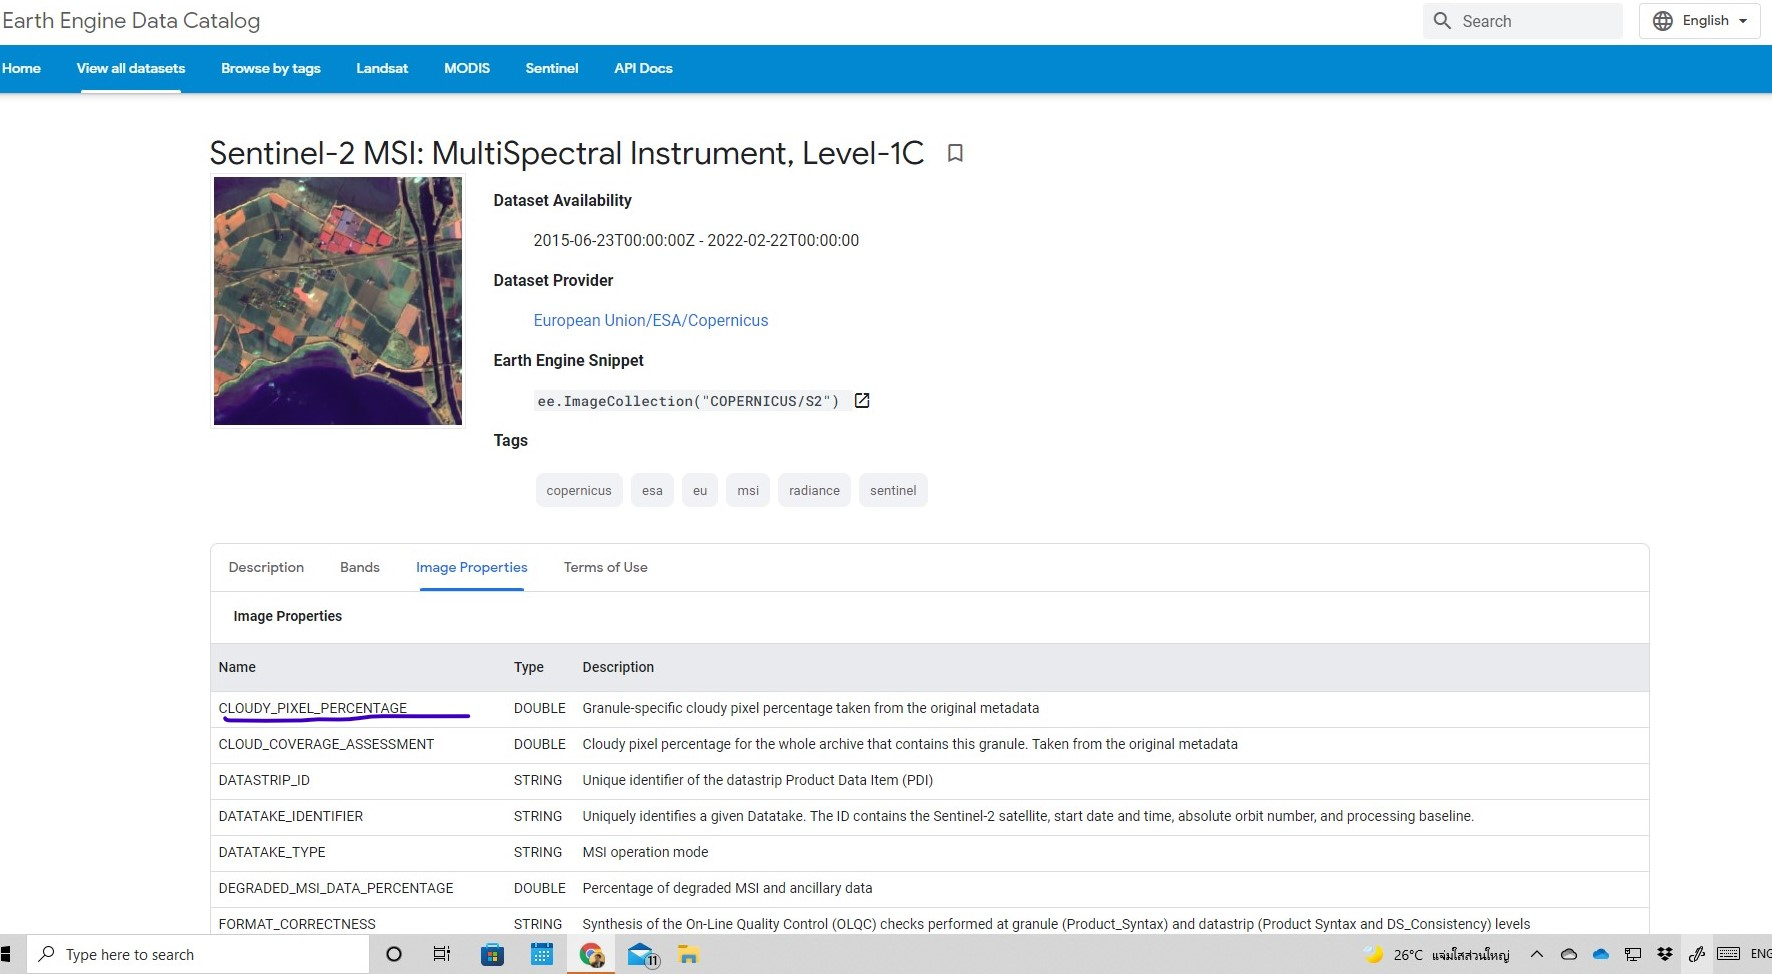

We need to filter for the key "CLOUDY_PIXEL_PERCENTAGE" with values less than 20%

In [ ]:
filter_cloud = ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20) # we create filter 
# cloud cover less than 20%
sen2collections = sen2collections.filter(filter_cloud)
bandsOfInterest = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"] #ignore Band 10
sen2collections = sen2collections.select(bandsOfInterest )
num_images = sen2collections.size().getInfo() # get the number of overlapped images
print(f"Sentinel2 image with less than 20% cloud cover: {num_images}")

## 10. Next step is for us to figure out when the image are talken

In [ ]:
sen2collections = sen2collections.sort("system:time_start") # sort by starting time
sen2_list = sen2collections.toList(num_images) 
# Convert the image collection to List so that we can access them by index 
for k in range(num_images): # for each on
  image = ee.Image(sen2_list.get(k)) # get the k-th item
  im_date = int(image.getInfo()['properties']['system:time_start']) 
  # extract date_time in the unix time value (microseconds)
  dateim = datetime.fromtimestamp(im_date/1000) # change to datetime object!!
  print(dateim)

## 11. Let us try to display the image on the Google Map. To do this, we will use folium library

In [ ]:
centroid = df.geometry[0].centroid # extract the shape centroid
yc, xc = centroid.y, centroid.x # get lattitude and longitude values
print(xc,yc) # print the value
folium_map = folium.Map(location=[yc, xc], zoom_start=13) #lon, lat and at zoom level 13 (more value higher detail)
basemaps = {'Google Maps': folium.TileLayer(
    tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',  #google map service site
    attr = 'Google',  
    name = 'Google Maps', 
    overlay = True,
    control=True)} # tell folium that the base map is the google map. 
basemaps['Google Maps'].add_to(folium_map) # add google earth data into ku_map
folium_map

## We also need to convert the DN to the surface reflectance. To do this, we will multiply all bands by $0.0001$.

In [ ]:
from ee import geometry
sen2collections = sen2collections.sort("system:time_start")
sen2_list = sen2collections.toList(num_images)
for k in range(num_images):  
  image = ee.Image(sen2_list.get(k))
  im_date = int(image.getInfo()['properties']['system:time_start'])
  image = image.multiply(0.0001)
  dateim = datetime.fromtimestamp(im_date/1000)  
  image_scene = image.clip(aoi) #Clip to only in AOI
  #To show image on a map, we need to build a visualization parameter first
  num_pix = image.reduceRegion(ee.Reducer.count(), geometry=aoi).getInfo()
  viz_params = {'bands':['B8','B3','B2'], 'min': 0,'max': 0.5} 
# red: B8, green: B3, blue: B2 with min of 0 and max of 0.5
  image_map_obj = image_scene.getMapId(viz_params) # convert image into map object
  folium.TileLayer(
    tiles=image_map_obj ['tile_fetcher'].url_format, #item where the image is linked to
    overlay=True,
    attr='Original Image',
    name=f'True Color Composite',
    ).add_to(folium_map)

folium_map

# Question1: What did you see in the above display?
_______________________________________________________________

# Question 2: Plot Histogram of all bands using the Google Earth Engine with 256 bins. Here, use "image" variable since it is the toa reflectance

In [ ]:
# bandsOfInterest = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"] 
# code is here


12. From Sentinel  [website](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-1c/algorithm), the TOA reflectance in the level 1C product is given as

    $\rho_k^T(i,j)=\frac{\pi CN_{k}(i,j)}{A_{k}E_sd(t)\cos(\theta_s(i,j))}$

where:
 * $ CN_{k}$ is the equalized DN at pixel (i,j)
 * $E_s$ is the extra-terrestrial solar spectrum
 * $d(t)=\frac{1}{\left(1-0.01673\cos\left(0.01752(t-2)\right)\right)^2}$   is the correction for the sun-Earth distance.
 * $\theta_s$ is the sun zenith angles (in degrees) witch can be extracted from the "MEAN_INCIDENCE_ZENITH_ANGLE_XX" properties.
 * $E_s$ is given in the properties "SOLAR_IRRADIANCE_XX" where XX denotes the band name.
 * $A_k$ = 0.0001

 We can recover the $TOA$ radiance by using

 $L^{sat}_k(i,j)=\frac{A_kE_s\cos(\theta_s)CN_{k}(i,j)}{\pi d^2(t)}$


Here, $t$ s the Julian Day (reference day:1-Jan-1950)

To compute the Julian Day, we are using the pandas library. 

In [ ]:
# Here is how to compute this
import pandas as pd 
scene_date = pd.Timestamp(year = dateim.year,  month = dateim.month, day = dateim.day) 
ref_date = pd.Timestamp(year = 1950,  month = 1, day = 1) 
t = scene_date.to_julian_date() - ref_date.to_julian_date()
print(t)

26118.0


# Question 3: Compute the TAO radiance on the Sentinel 2 on this scene

In [ ]:
# your code is here.
# Use Ak = 0.0001
#     E FROM SOLAR_IRRADIANCE_
#     theta from MEAN_INCIDENCE_ZENITH_ANGLE_
toa_radiance = None # initialize as Nont
imorg = ee.Image(sen2_list.get(0)) # get the first image again  


# Question 4: Display your Image on the folium library just like in the demonstration. 


In [ ]:
# your code is here


# Question 5: Plot the histogram of the TAO radiance of all bands using the google earth engine with 256 bins.

## 13. From our optical radiation model, we have

$L_k^{sat}(i,j)=\rho_k^{B}(i,j)\tau_k\left(E_{dir} + E_{dif}\right) + L_p$

Thus, to compute $\rho_k^{B}(i,j)$, we need to estimate $E_{dir}$, $E_{dif}$, $L_p$ and $\tau_k$

where
*  $\rho_k^{B}(i,j)$ is the surface reflectance.
*  $E_{dir}$ is the direct solar irradiance.
*  $E_{dif}$ is the diffuse solar irradiance.
* $L_p$ is the path radiance.





## Using the SixS modules, to compute these values for each band in bandOfInterest

Note here that the solor zenith angle is different from differnt bands.!!! Check "MEAN_INCIDENCE_ZENITH_ANGLE_XX"
Also the satellite name is in SPACECRAFT_NAME in the Google Earth Engine

In [ ]:
# Your code is here for initialize all sixS processes. 

# Question 5: Fill in the Blank


1.   $E_{dir}$ for B1= _________________________, $E_{dif}$ for B1= _________________________, and $L_{p}$ for B1= _________________________. 
2.   $E_{dir}$ for B2= _________________________, $E_{dif}$ for B2= _________________________, and $L_{p}$ for B2= _________________________. 
3.   $E_{dir}$ for B3= _________________________, $E_{dif}$ for B3= _________________________, and $L_{p}$ for B3= _________________________. 
4.   $E_{dir}$ for B4= _________________________, $E_{dif}$ for B4= _________________________, and $L_{p}$ for B4= _________________________. 
5.   $E_{dir}$ for B5= _________________________, $E_{dif}$ for B5= _________________________, and $L_{p}$ for B5= _________________________. 
6.   $E_{dir}$ for B6= _________________________, $E_{dif}$ for B6= _________________________, and $L_{p}$ for B6= _________________________. 
7.   $E_{dir}$ for B7= _________________________, $E_{dif}$ for B7= _________________________, and $L_{p}$ for B7= _________________________. 
8.   $E_{dir}$ for B8= _________________________, $E_{dif}$ for B8= _________________________, and $L_{p}$ for B8= _________________________. 

9.   $E_{dir}$ for B8A= _________________________, $E_{dif}$ for B8A= _________________________, and $L_{p}$ for B8A= _________________________. 

10.   $E_{dir}$ for B9= _________________________, $E_{dif}$ for B9= _________________________, and $L_{p}$ for B9= _________________________. 
11.   $E_{dir}$ for B11= _________________________, $E_{dif}$ for B11= _________________________, and $L_{p}$ for B11= _________________________. 
12.   $E_{dir}$ for B12= _________________________, $E_{dif}$ for B12= _________________________, and $L_{p}$ for B12= _________________________. 

In [ ]:
# your code is here

# Question 7: Compute the surface reflectance using the computed values above using Google Earth Engine.

In [ ]:
# Add your code here.

# Question 8: Plot the histogram of the surface reflectance of all bands using the google earth engine with 256 bins.

In [ ]:
# your code is here


# Question 9: Display this image on the folium.

In [ ]:
# your code is here.


# Question 10: Load the same image in the same AOI using the Google Earth Surface Reflectance (Level 2A) using ee.Image("COPERNICUS/S2_SR"), and compare the histograms from both original Sentinel2 Level 2A and our generated data in Question 8.

In [ ]:
# Your code is here.


## Question 11: Display image from the orignal Surface reflectance